In [1]:
from qiskit import __version__
print(__version__)

1.4.1


In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import galois

Deutsch's algorithm


To be precise, the input is represented by a function 
f:Σ→Σ from one bit to one bit. There are 4 such functions:

\begin{array}{c|c} 
a & f_1(a) \\
\hline 
0 & 0 \\
1 & 0 \\
\end{array}

\begin{array}{c|c} 
a & f_2(a) \\
\hline 
0 & 0 \\
1 & 1 \\
\end{array}

\begin{array}{c|c} 
a & f_3(a) \\
\hline 
0 & 1 \\
1 & 0 \\
\end{array}

\begin{array}{c|c} 
a & f_4(a) \\
\hline 
0 & 1 \\
1 & 1 \\
\end{array}

f1, f4 -> constant
f2, f3 -> balanced


In [3]:
def deutsch_function(case: int):
    # This function generates a quantum circuit for one of the 4 functions
    # from one bit to one bit

    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f

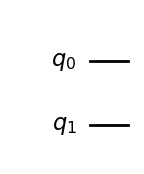

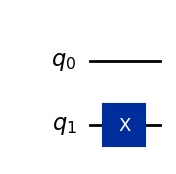

In [ ]:
# constant
display(deutsch_function(1).draw(output="mpl"))
display(deutsch_function(4).draw(output="mpl"))

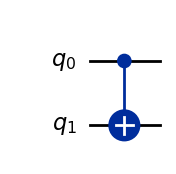

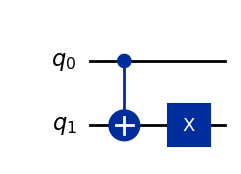

In [23]:
# balanced
display(deutsch_function(2).draw(output="mpl"))
display(deutsch_function(3).draw(output="mpl"))

In [6]:
def compile_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in Deutsch's algorithm.

    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)

    qc.x(n)
    qc.h(range(n + 1))

    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()

    qc.h(range(n))
    qc.measure(range(n), range(n))

    return qc

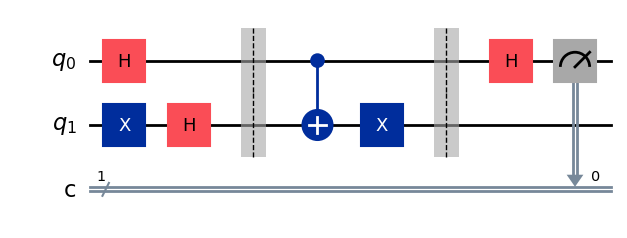

In [7]:
display(compile_circuit(deutsch_function(3)).draw(output="mpl"))

In [8]:
def deutsch_algorithm(function: QuantumCircuit):
    # Determine if a one-bit function is constant or balanced.

    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if measurements[0] == "0":
        return "constant"
    return "balanced"

In [9]:
f = deutsch_function(3)
display(deutsch_algorithm(f))

'balanced'

The Deutsch-Jozsa algorithm


In [10]:
def dj_query(num_qubits):
    # Create a circuit implementing for a query gate for a random function
    # satisfying the promise for the Deutsch-Jozsa problem.

    qc = QuantumCircuit(num_qubits + 1)

    if np.random.randint(0, 2):
        # Flip output qubit with 50% chance
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc

    # Choose half the possible input strings
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )

    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        qc.barrier()  # Barriers are added to help visualize how the functions are created.
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits)
        qc = add_cx(qc, f"{state:0b}")

    qc.barrier()

    return qc

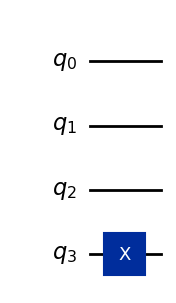

In [11]:
display(dj_query(3).draw(output="mpl"))

In [12]:
def compile_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in the Deutsch-Jozsa algorithm.

    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

In [13]:
def dj_algorithm(function: QuantumCircuit):
    # Determine if a function is constant or balanced.

    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if "1" in measurements[0]:
        return "balanced"
    return "constant"

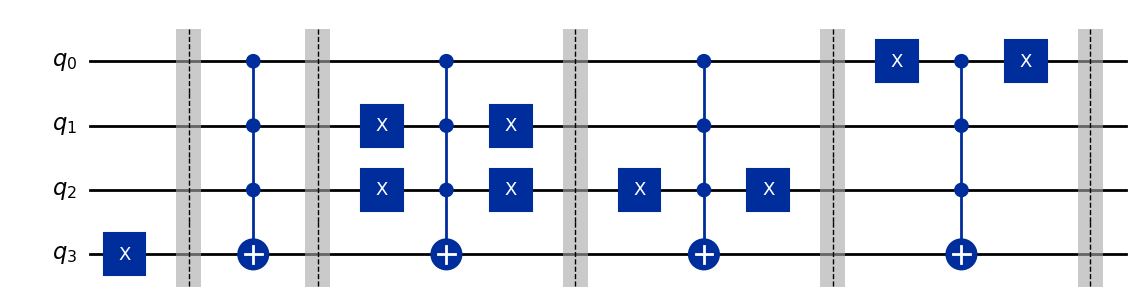

'balanced'

In [14]:
f = dj_query(3)
display(f.draw("mpl"))
display(dj_algorithm(f))

Bernstein-Vazirani 

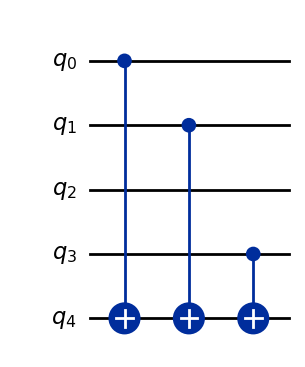

In [15]:
def bv_query(s):
    # Create a quantum circuit implementing a query gate for the
    # Bernstein-Vazirani problem.

    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, len(s))
    return qc

display(bv_query("1011").draw(output="mpl"))

In [16]:
def bv_algorithm(function: QuantumCircuit):
    qc = compile_circuit(function)
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    return result.get_memory()[0]

display(bv_algorithm(bv_query("1011")))

'1011'

Simon's algorithm

In [17]:
def simon_function(s: str):
    # Create a QuantumCircuit implementing a query gate for Simon problem obeying the
    # promise for the hidden string `s`

    # The quantum circuit will have 2n qubits for n being the length of s
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Define a random permutation of all n bit strings. This permutation will
    # effectively hide the string s.
    pi = np.random.permutation(2**n)

    # Now we'll define a query gate explicitly. The idea is to first define a function
    # g(x) = min{x,x ^ s}, which is a very simple function that satisfies the promise.
    # (The operation ^ is the bitwise XOR.) Then we take f to be the composition of g
    # and the random permutation pi. This gives us a random function satisfying the
    # promise for s.

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1

    # Our circuit has just this one query gate
    qc.unitary(query_gate, range(2 * n))
    return qc

In [18]:
def simon_measurements(problem: QuantumCircuit, k: int):
    # This is the quantum part of Simon's algorithm. Given a `QuantumCircuit` that
    # implements f, gets k measurement outcomes to be post-processed later.

    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    result = AerSimulator().run(qc, shots=k, memory=True).result()
    return result.get_memory()

In [19]:
display(simon_measurements(simon_function("10011"),k=12))

['10110',
 '11110',
 '00111',
 '10110',
 '00100',
 '11101',
 '01011',
 '00111',
 '00100',
 '10110',
 '00111',
 '11010']

In [20]:
def simon_algorithm(problem: QuantumCircuit):
    # Given a `QuantumCircuit` that implements a query gate for Simon problem, return
    # the hidden string `s`.

    # Quantum part: run the circuit defined previously k times and gather the measurement
    # results. Replace +10 by +r for any nonnegative integer r depending on desired
    # confidence.

    measurements = simon_measurements(problem, k=problem.num_qubits // 2 + 10)

    # Classical post-processing:

    # 1. Convert measurements of form '11101' to 2D-array of integers
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    # 2. Interpret matrix as using arithmetic mod 2, and find null space
    null_space = galois.GF(2)(matrix).null_space()

    # 3. Convert back to a string
    print("Guess for hidden string s: ")
    if len(null_space) == 0:
        # No non-trivial solution; `s` is all-zeros
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))

In [21]:
display(simon_algorithm(simon_function("10011")))

Guess for hidden string s: 


'10011'